<a href="https://colab.research.google.com/github/VallabhK/ExperimentsWithData/blob/master/FutureSalesPrediction1CCompany.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Future Sales Prediction**

**Problem Statement:** In this competition you will work with a challenging time-series dataset consisting of daily sales data, kindly provided by one of the largest Russian software firms - 1C Company. 

We are asking you to predict total sales for every product and store in the next month. Develop a robust model which can handle slight changes in list of shops and products.

References: https://www.kaggle.com/jagangupta/time-series-basics-exploring-traditional-ts 

In [1]:
#importing libraries

import pandas as pd #Data processing
import numpy as np #Matrix/Linear algebraic operations
import random as rd #Random number 
import datetime #date formats

#Visualization packages
from matplotlib import pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
path_to_directory = 'https://raw.githubusercontent.com/VallabhK/ExperimentsWithData/master/Input/'

In [0]:
#importing data and converting to pandas dataframe

url = path_to_directory + 'sales_train.csv'
salestrain = pd.read_csv(url);

In [4]:
#checking imported data
salestrain.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [0]:
#splitting date into day, month and year
new = salestrain['date'].str.split(".", expand = True) 

#creating new columns to store date
salestrain['day'] = new[0]
salestrain['month'] = new[1]
salestrain['year'] = new[2]

In [6]:
salestrain.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year
0,02.01.2013,0,59,22154,999.00,1.0,02,01,2013
1,03.01.2013,0,25,2552,899.00,1.0,03,01,2013
2,05.01.2013,0,25,2552,899.00,-1.0,05,01,2013
3,06.01.2013,0,25,2554,1709.05,1.0,06,01,2013
4,15.01.2013,0,25,2555,1099.00,1.0,15,01,2013


In [0]:
import warnings
warnings.filterwarnings("ignore")

**File descriptions**
* sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
* test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
* sample_submission.csv - a sample submission file in the correct format.
* items.csv - supplemental information about the items/products.
* item_categories.csv  - supplemental information about the items categories.
* shops.csv- supplemental information about the shops.

In [0]:
#Reading all the data files
item_categories = pd.read_csv(path_to_directory + 'item_categories.csv');
items = pd.read_csv(path_to_directory + 'items.csv');
sample_submission = pd.read_csv(path_to_directory + 'sample_submission.csv');
shops = pd.read_csv(path_to_directory + 'shops.csv');
test = pd.read_csv(path_to_directory + 'test.csv')


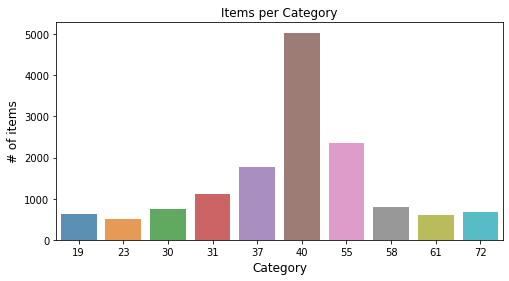

In [9]:
x=items.groupby(['item_category_id']).count()
x=x.sort_values(by='item_id',ascending=False)
x=x.iloc[0:10].reset_index()
plt.figure(figsize=(8,4))
ax= sns.barplot(x.item_category_id, x.item_id, alpha=0.8)
plt.title("Items per Category")
plt.ylabel('# of items', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.show()

In [0]:
salestrain['date'] = pd.to_datetime(salestrain['date'], infer_datetime_format=True)
indexedSalesDataset = salestrain.set_index(['date'])


In [0]:
#Average the monthly sales and group them by month, shop_id and item_id

SalesPerMonth = salestrain.groupby(["date_block_num","shop_id","item_id"])[
    "date","item_price","item_cnt_day"].agg({"date":["min",'max'],"item_price":"mean","item_cnt_day":"sum"})

In [12]:
SalesPerMonth

date            item_price item_cnt_day
                                      min        max       mean          sum
date_block_num shop_id item_id                                              
0              0       32      2013-01-21 2013-03-01      221.0          6.0
                       33      2013-01-17 2013-03-01      347.0          3.0
                       35      2013-01-31 2013-01-31      247.0          1.0
                       43      2013-01-31 2013-01-31      221.0          1.0
                       51      2013-01-13 2013-01-31      128.5          2.0
...                                   ...        ...        ...          ...
33             59      22087   2015-05-10 2015-10-23      119.0          6.0
                       22088   2015-03-10 2015-10-27      119.0          2.0
                       22091   2015-03-10 2015-03-10      179.0          1.0
                       22100   2015-10-18 2015-10-18      629.0          1.0
                       22102   2015-10-16 2015-10-16     1250.0          1.0

[1609124 rows x 4 columns]

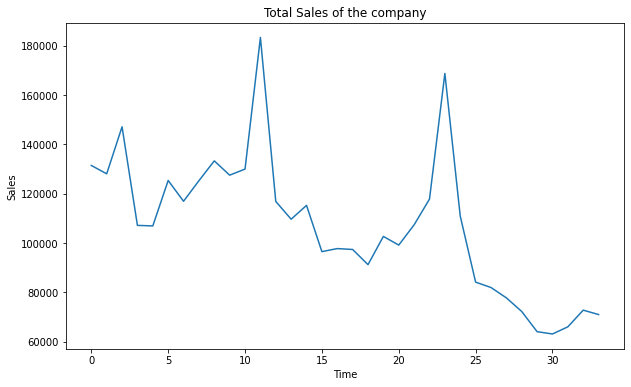

In [13]:
#Take the summation of the values for all the months for a particular item
TotalSales = salestrain.groupby(["date_block_num"])["item_cnt_day"].sum()
TotalSales.astype('float')
plt.figure(figsize=(10,6))
plt.title("Total Sales of the company")
plt.xlabel("Time")
plt.ylabel("Sales")
plt.plot(TotalSales);


In [14]:
#Check whether the data is stationary 
rollingMean = TotalSales.rolling(window=12, center = False).mean() #The value of window is 12 because we are computing on a monthly basis
rollingStd = TotalSales.rolling(window=12, center = False).std()
print(rollingMean, rollingStd)

date_block_num
0               NaN
1               NaN
2               NaN
3               NaN
4               NaN
5               NaN
6               NaN
7               NaN
8               NaN
9               NaN
10              NaN
11    130227.750000
12    129012.750000
13    127479.166667
14    124825.416667
15    123939.250000
16    123174.250000
17    120844.916667
18    118704.416667
19    116823.583333
20    113979.916667
21    112303.333333
22    111289.666667
23    110074.083333
24    109580.083333
25    107456.000000
26    104682.416667
27    103121.666667
28    100997.083333
29     98220.833333
30     95879.750000
31     92826.250000
32     90629.166667
33     87598.666667
Name: item_cnt_day, dtype: float64 date_block_num
0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
5              NaN
6              NaN
7              NaN
8              NaN
9              NaN
10             NaN
11    20058.213489
12    20413.957930
13    21

It can be observed from the data that their is seasonality in the data as the trend decreases after a certain time interval

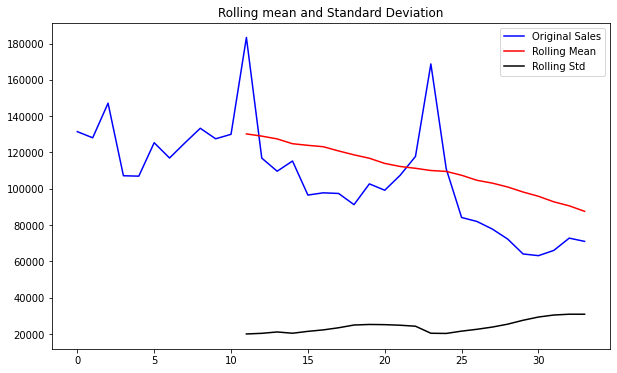

In [15]:
plt.figure(figsize=(10,6))
originalSales = plt.plot(TotalSales , color= 'blue', label = 'Original Sales')
mean = plt.plot(rollingMean, color = 'red', label = 'Rolling Mean')
std = plt.plot(rollingStd, color = 'black', label ='Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling mean and Standard Deviation')
plt.show(block =False)

In [16]:
#We can also check the stationarity of the data by using Augmented Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

print('Results of Dickey Fuller test:')
dftest = adfuller(TotalSales.values, autolag ='AIC') # the lag function used here can be changed based on type of data

dfoutput = pd.Series(dftest[0:4], index =['Test Statistics', 'p-value', '#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
  dfoutput['Critical Value (%s)'%key] = value

print(dfoutput)

Results of Dickey Fuller test:
Test Statistics                -2.395704
p-value                         0.142953
#Lags Used                      0.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64


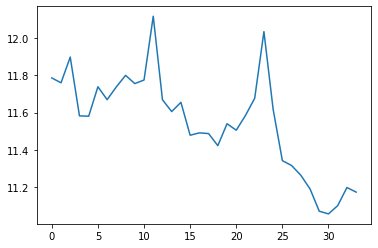

In [17]:
TotalSales_logData = np.log(TotalSales)
plt.plot(TotalSales_logData)